<a href="https://colab.research.google.com/github/entirety2019/Meetup2019/blob/master/Session3/Pytorch_Dog_vs_Cat_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')
#* updating filepath to your Google Drive

#Make sure you have this path available in your google drive
filepath="/content/gdrive/My Drive/Meetup2019/Models/vgg19/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install  kaggle

In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
#!mkdir ~/.kaggle
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2522            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9909           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4103           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2381           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [5]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 70.9MB/s]
 95% 257M/271M [00:03<00:00, 108MB/s] 
100% 271M/271M [00:03<00:00, 91.0MB/s]
 96% 521M/543M [00:12<00:00, 36.7MB/s]
100% 543M/543M [00:12<00:00, 45.7MB/s]


In [0]:
!unzip -qq train.zip
!unzip -qq test1.zip

In [0]:
!rm train.zip
!rm test1.zip

In [8]:
!ls

adc.json  gdrive  sample_data  sampleSubmission.csv  test1  train


In [0]:
!mkdir /content/train/cat
!mkdir /content/train/dog

In [0]:
!bash -c 'mv /content/train/cat.{0..9999}.jpg /content/train/cat'
!bash -c 'mv /content/train/dog.{0..9999}.jpg /content/train/dog'

In [11]:
ls train/cat -1 | wc -l

10000


In [12]:
ls train/dog -1 | wc -l

10000


Implementation

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [14]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
PATH=Path('/content/')

In [59]:
TRAIN =Path(PATH/'train')
TEST=Path(PATH/'test1')
print(TRAIN)
print(TEST)

/content/train
/content/test1


In [61]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#valid_transforms = transforms.Compose([transforms.Resize((224,224)),
 #                                     transforms.ToTensor(),
  #                                    transforms.Normalize([0.485, 0.456, 0.406],
   #                                                        [0.229, 0.224, 0.225])])
# choose the training and test datasets

#test_transforms = transforms.Compose([transforms.Resize((224,224)),
 #                                     transforms.ToTensor(),
  #                                    transforms.Normalize([0.485, 0.456, 0.406],
   #                                                        [0.229, 0.224, 0.225])])
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
#valid_data=datasets.ImageFolder(VALID,transform=valid_transforms)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
print("Split Index",split)
train_idx, valid_idx = indices[split:], indices[:split]


Split Index 4000


In [0]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [21]:
print(train_data.class_to_idx)

{'cat': 0, 'dog': 1}


In [0]:
images,labels=next(iter(train_loader))

In [23]:
images.shape,labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['cat','dog']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

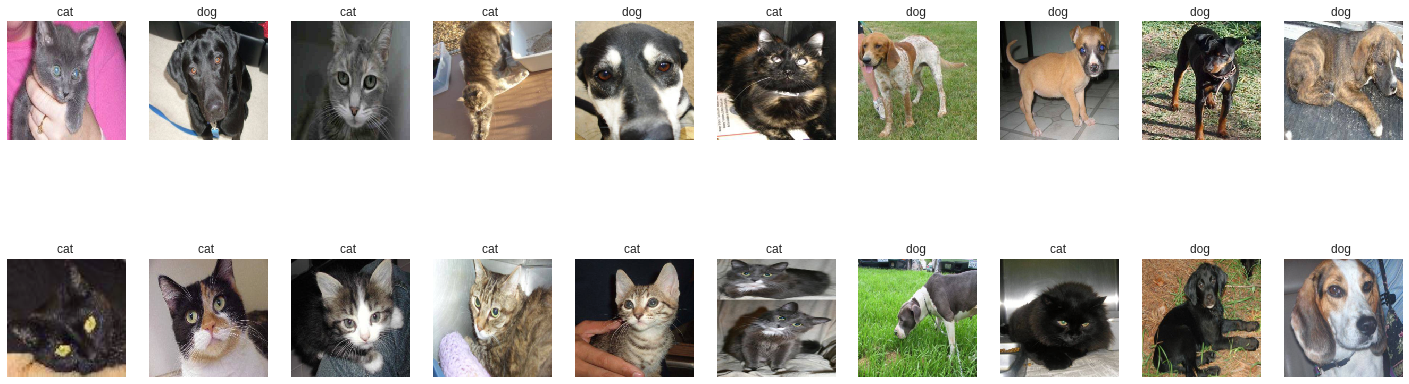

In [25]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

![](http://)Load the model VGG -19

In [26]:
vgg_19=models.vgg19_bn(pretrained=True)
vgg_19

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.torch/models/vgg19_bn-c79401a0.pth
574769405it [00:07, 80866941.00it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
# Freeze parameters so we don't backprop through them
for param in vgg_19.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1028)),
                          ('relu1', nn.ReLU()),
                          ('dropout1',nn.Dropout(0.5)),
                          ('fc2', nn.Linear(1028, 512)),
                          ('relu2', nn.ReLU()), 
                          ('dropout2',nn.Dropout(0.5)),
                          ('fc3', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
vgg_19.classifier = classifier

In [28]:
vgg_19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
criterion = nn.NLLLoss()
optimizer=torch.optim.Adam(vgg_19.parameters(),lr=0.01)

In [0]:

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [47]:
if train_on_gpu:
    vgg_19.cuda()
# number of epochs to train the model
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    vgg_19.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    vgg_19.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg_19.state_dict(), '/content/gdrive/My Drive/Meetup2019/Models/vgg19/model_vgg19.pth')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.864022 	Validation Loss: 0.339995
Validation loss decreased (inf --> 0.339995).  Saving model ...
Epoch: 2 	Training Loss: 1.191201 	Validation Loss: 0.344543
Epoch: 3 	Training Loss: 0.614482 	Validation Loss: 0.124974
Validation loss decreased (0.339995 --> 0.124974).  Saving model ...


In [48]:
batch_size=4
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg_19.eval()
# iterate over valid data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg_19(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.124974

Test Accuracy of   cat: 87% (1737/1988)
Test Accuracy of   dog: 99% (2006/2012)

Test Accuracy (Overall): 93% (3743/4000)


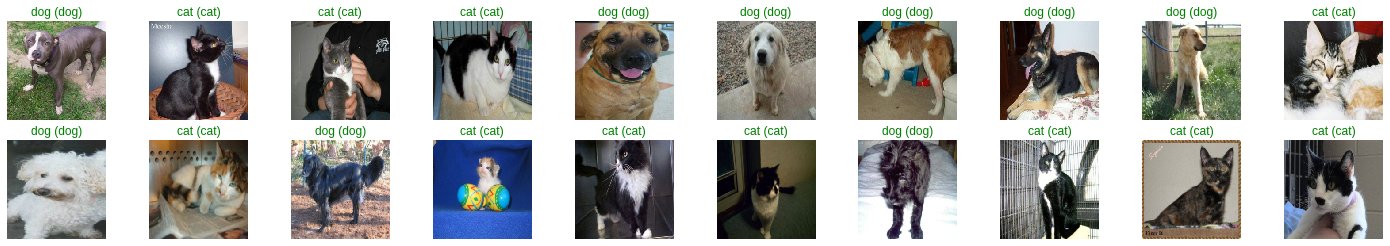

In [49]:
batch_size=32
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
vgg_19.cpu()
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
#if train_on_gpu:
    #images = images.cuda()

# get sample outputs
output = vgg_19(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [50]:
print("The state dict keys: \n\n", vgg_19.state_dict().keys())

The state dict keys: 

 odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'fe

vgg_19.load_state_dict(state_dict)

In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(vgg_19.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 3 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Number of epochs

In [52]:

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

if train_on_gpu:
    vgg_19.cuda()
# number of epochs to train the model
n_epochs = 2

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    vgg_19.train()
    
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        scheduler.step()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    vgg_19.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg_19.state_dict(), '/content/gdrive/My Drive/Meetup2019/Models/vgg19/model_vgg19_2.pth')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.502295 	Validation Loss: 0.118242
Validation loss decreased (inf --> 0.118242).  Saving model ...
Epoch: 2 	Training Loss: 0.711761 	Validation Loss: 0.119895


In [54]:
batch_size=4
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg_19.eval()
# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg_19(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.119895

Test Accuracy of   cat: 85% (1696/1988)
Test Accuracy of   dog: 99% (2007/2012)

Test Accuracy (Overall): 92% (3703/4000)


In [0]:
!mkdir /content/test1/test1

In [0]:
!bash -c 'mv /content/test1/{1..12500}.jpg /content/test1/test1'

In [0]:
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
test_data = datasets.ImageFolder(TEST, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

In [0]:
pred_list=[]

In [0]:
batch_size=32
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)
for data,labels in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data = data.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output=vgg_19(data)
    _,pred=torch.max(output,1)
    pred_list.extend(pred.data.cpu().detach().numpy())

In [164]:
import pandas as pd
submission=pd.read_csv("/content/sampleSubmission.csv")
submission.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
image_idx=[]
for i in range(0,len(test_data.imgs)):
    image_idx.append(int((Path(test_data.imgs[i][0]).name.split(".")[0])))

In [180]:
submission=pd.DataFrame({"id":image_idx,"label":pred_list})
submission.shape

(12500, 2)

In [181]:
submission.head()


,id,label
0,1,1
1,10,0
2,100,1
3,1000,1
4,10000,1


In [0]:
submission.to_csv("submission_vgg19.csv",index=False)
from google.colab import files
files.download('submission_vgg19.csv') 

References
<br>
[Notebook](https://www.kaggle.com/pocahontas1010/cats-dogs-classifier-with-pytorch/notebook)
<br>
[Sorting data into subdirectories](https://www.kaggle.com/c/dog-breed-identification/discussion/48908)
<br>
[Model evaluation](https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch)
<br>
[Pytorch Models](https://pytorch.org/docs/stable/torchvision/models.html)
<br>
[Pytorch Augmetation](https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll)